# Regular Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
def gaussian_kernel(x1,x2,kernel_size=0.2):
    return np.exp(-((x1-x2)@(x1-x2))/(2*kernel_size**2))


def XX(X,Y):
    A=np.zeros((X.T.shape[0],Y.shape[1])) #m*m
    for i in range(X.T.shape[0]): #m
        for j in range(Y.shape[1]): #m
            A[i,j]=gaussian_kernel(X.T[i,:],Y[:,j])
    return A


def Kalman_in(data,m=150,lamda=1e-3,c=1e-5,q=0.2,r=0.5):
    
    n=len(data[0,:])
    Y0=data[:,2:m+2]
    Upsilon=data[:,1:m+1] #phi(Upsilon)
    Phi=data[:,2:m+2] #phi(Phi)

    K=XX(Upsilon,Upsilon)
    M=XX(Phi,Phi)
    T=XX(Upsilon,Phi)

#     c=1e-5 # regularization term
    L=np.linalg.inv(K+c*m*np.eye(m))

#     lamda=1e-3
    P0=lamda*np.eye(m)
    u0=Y[:,0].reshape(Y[:,0].shape[0],1)
    a1=L@XX(Upsilon,u0)

    P_1=lamda*L@K@L.T

#     q=0.2
#     r=0.5
#     beta=1

    return [n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r]


def Kalman_fil(n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r):
    G=[]
    P=[]
    b=[]
    x=[]
    a=[a1]
    P_=[P_1]
    for i in tqdm(range(n)):
    
        G.append( np.linalg.inv((q+r)*np.eye(m)+P_[i]@M)@P_[i] )

        P.append( r/(r+q)*P_[i] - r/(r+q)*G[i]@M@P_[i] - q*r/(q+r)*G[i] )

        phi_yi=Y[:,i].reshape(Y[:,0].shape[0],1)
        b.append( (r/(q+r)*np.eye(m) - r/(q+r)*G[i]@M)@a[i] + r/(q+r)*G[i]@XX(Phi,phi_yi) )

        x.append( Y0@b[i] + q/(q+r)*Y[:,i] )

        a.append( L@XX(Upsilon,Phi)@b[i] + q/(q+r)*L@XX(Upsilon,phi_yi) )

        P_.append( L@T@P[i]@T.T@L.T + q*r/(q+r)*L@K@L.T )
    return np.array(x).reshape(n)

## Generating data

In [3]:
n=300 #number of data
m=150 #number of training data
i= np.array(range(n))
t=i*0.04
noise_var=0.5 #variance of the noise
noise=np.random.normal(0, noise_var, size=(1,n))
Ys=4*np.sin(2*np.pi*t).reshape(1,n)
Y=Ys+noise #y0,y1,...,ym+1

## Initializing

In [4]:
[n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r]=Kalman_in(Y)

## filtering

In [5]:
x=Kalman_fil(n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r)
Ys=Ys.reshape(n)
Y=Y.reshape(n)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s]


## Ploting

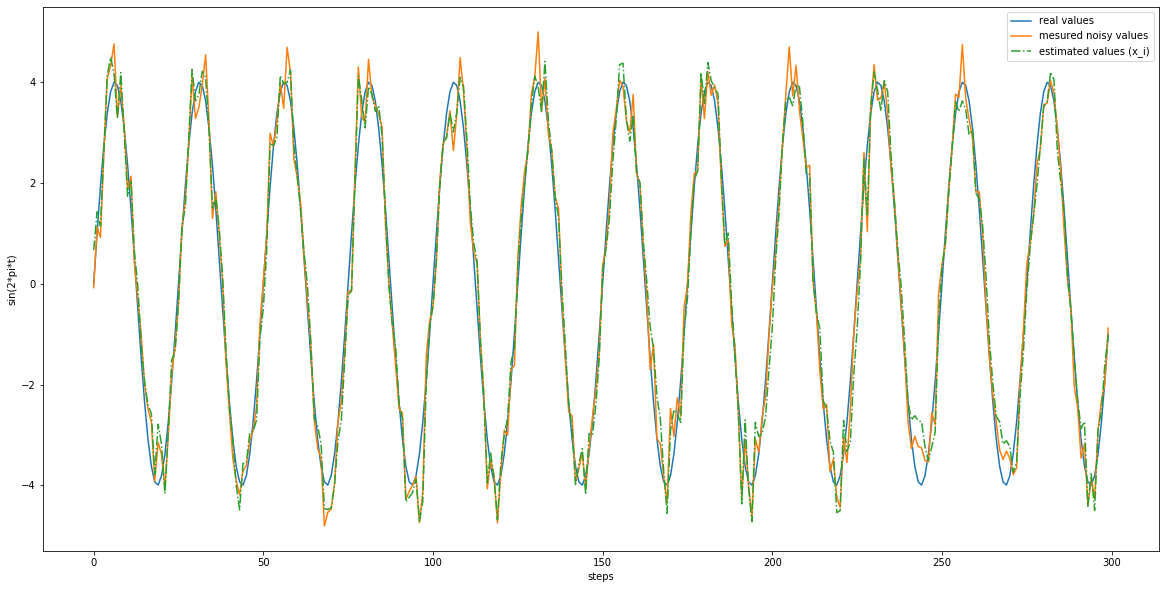

In [7]:
plt.figure(figsize=(20,10))
plt.ylabel('sin(2*pi*t)')
plt.xlabel('steps')
plt.plot(Ys,label='real values')
plt.plot(Y,label='mesured noisy values',linestyle="-")
plt.plot(x,label='estimated values (x_i)',linestyle="-.")

plt.legend()
plt.show()

In [8]:
mean_squared_error(Ys[m:],x[m:])

0.3039624525813301

## Kalman Filter with Different Noise

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 12.55it/s]


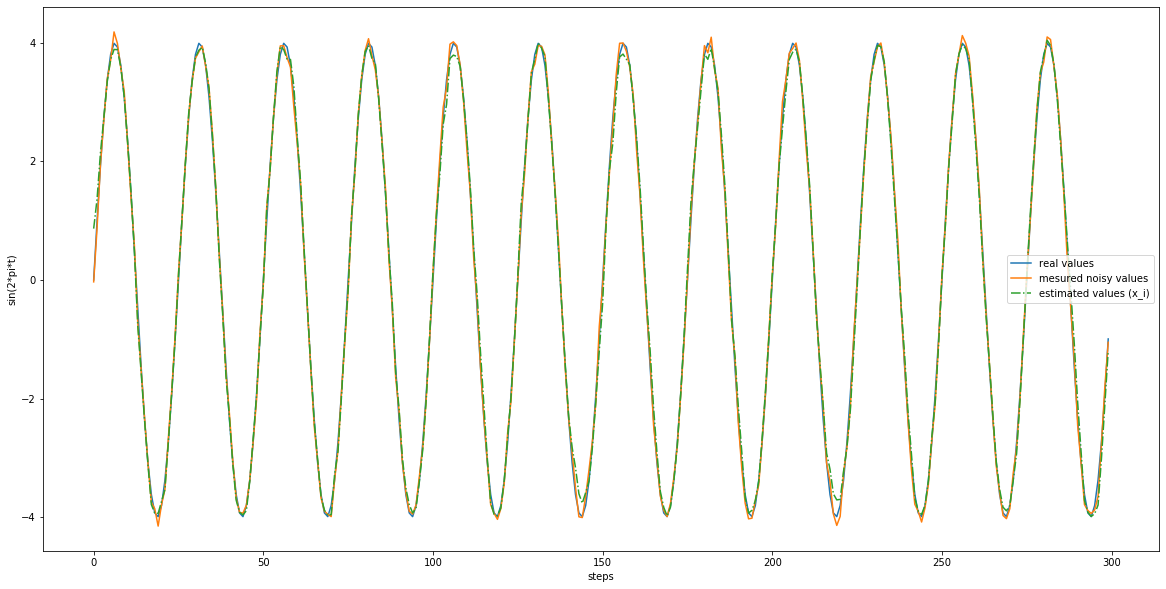

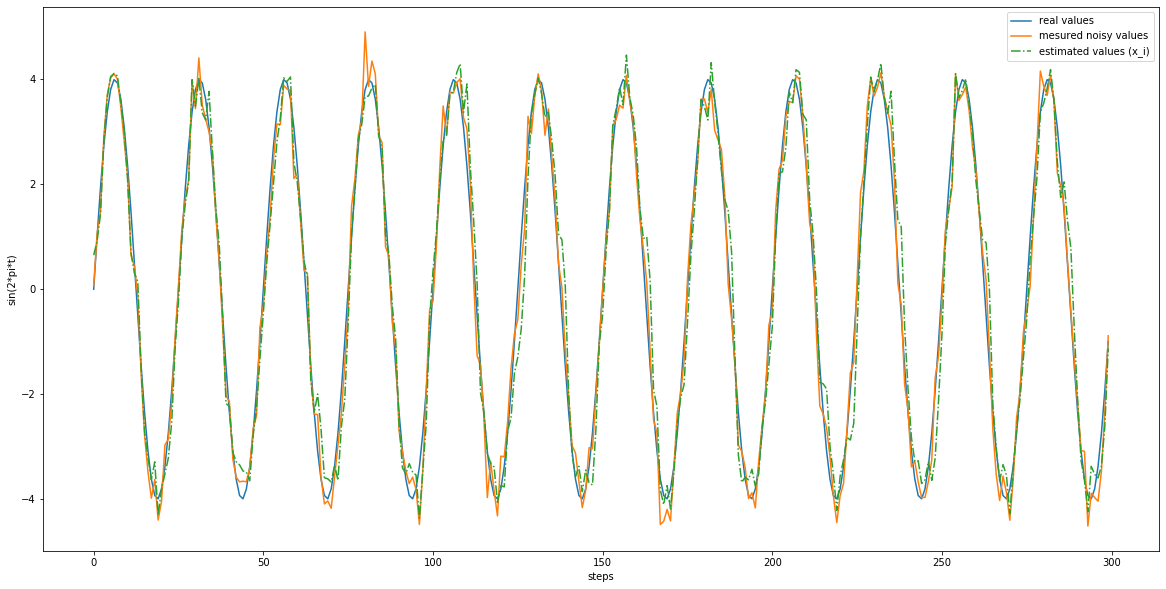

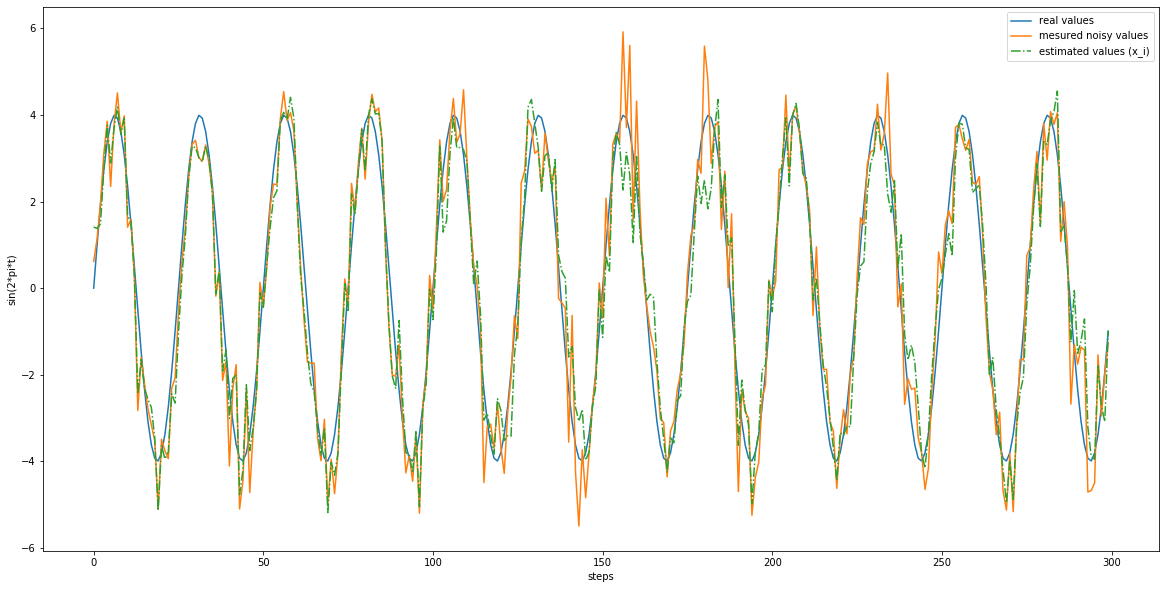

In [6]:
ERR=[]
YYss=[]
YY=[]
xx=[]

for noise_var in [.1,.4,.9]:
    
    # generating data
    n=300 #number of data
    i= np.array(range(n))
    t=i*0.04
    noise=np.random.normal(0, noise_var, size=(1,n))
    Ys=4*np.sin(2*np.pi*t).reshape(1,n)
    Y=Ys+noise #y0,y1,...,ym+1
    
    # Initializing
    [n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r]=Kalman_in(Y,m=100)

    # filtering
    x=Kalman_fil(n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r)
    Ys=Ys.reshape(n)
    Y=Y.reshape(n)
    x=np.array(x).reshape(n)
    YYss.append(Ys)
    YY.append(Y)
    xx.append(x)

    ERR.append(mean_squared_error(Ys[m:],x[m:]))

    plt.figure(figsize=(20,10))
    plt.ylabel('sin(2*pi*t)')
    plt.xlabel('steps')
    plt.plot(Ys,label='real values')
    plt.plot(Y,label='mesured noisy values',linestyle="-")
    plt.plot(x,label='estimated values (x_i)',linestyle="-.")

    plt.legend()

plt.show()

In [7]:
ERR

[0.021355576893968525, 0.3649280500061849, 0.7965653120046166]

## Regular Kalman with arbitrary input


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:29<00:00,  3.18it/s]


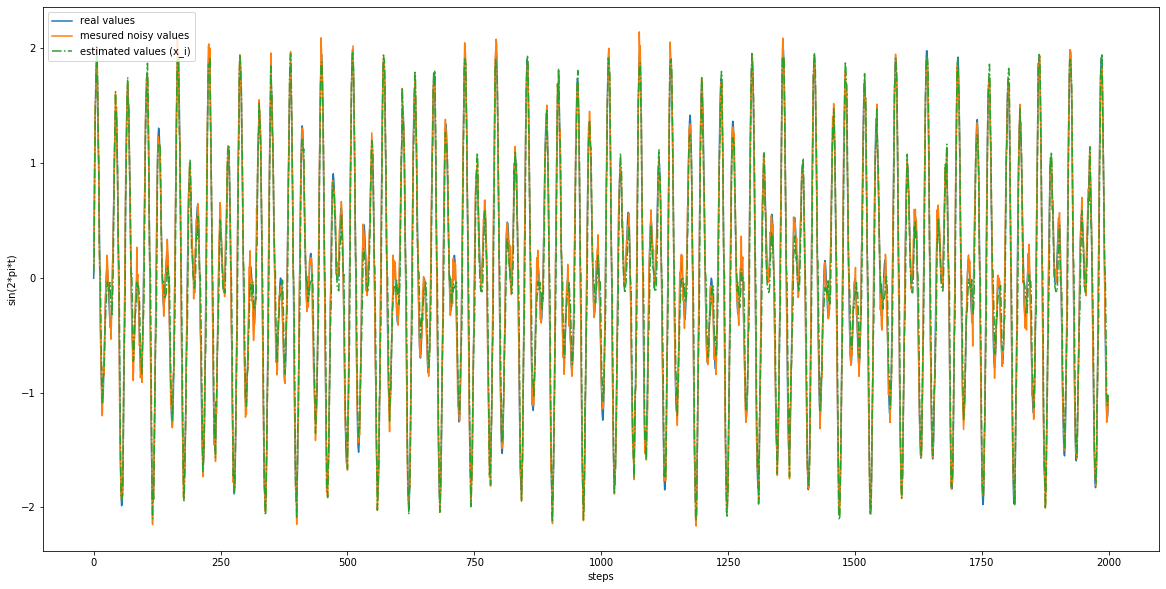

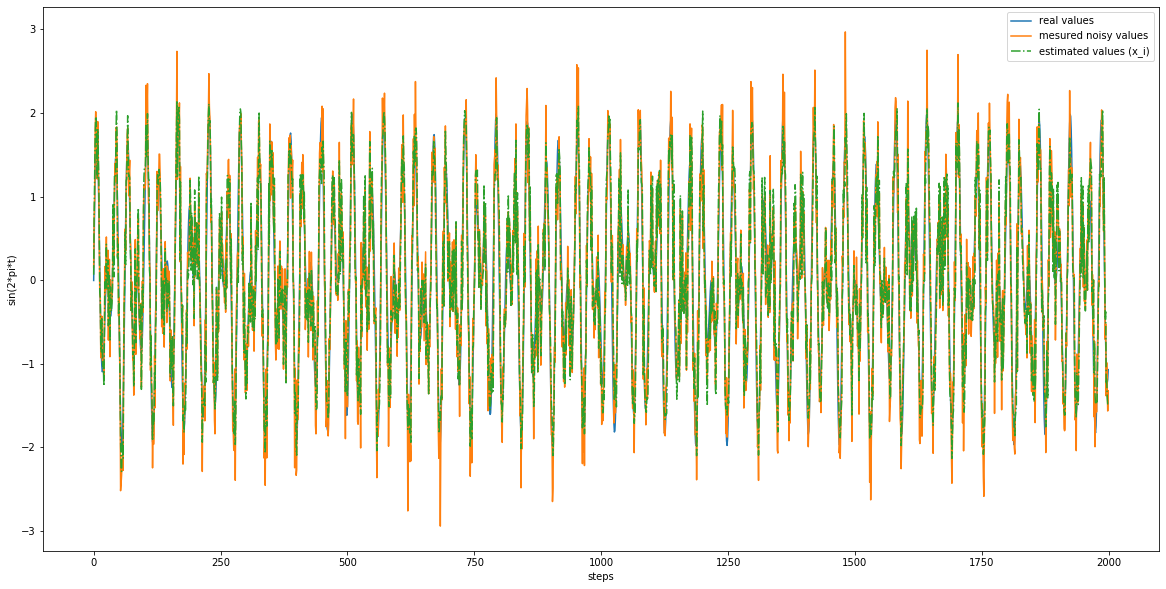

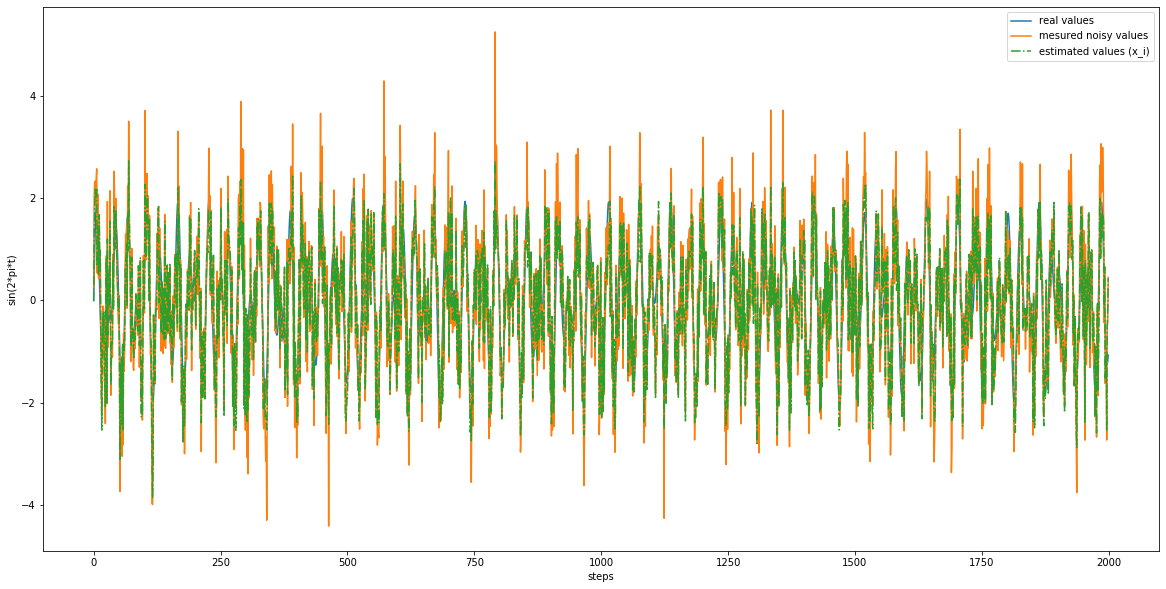

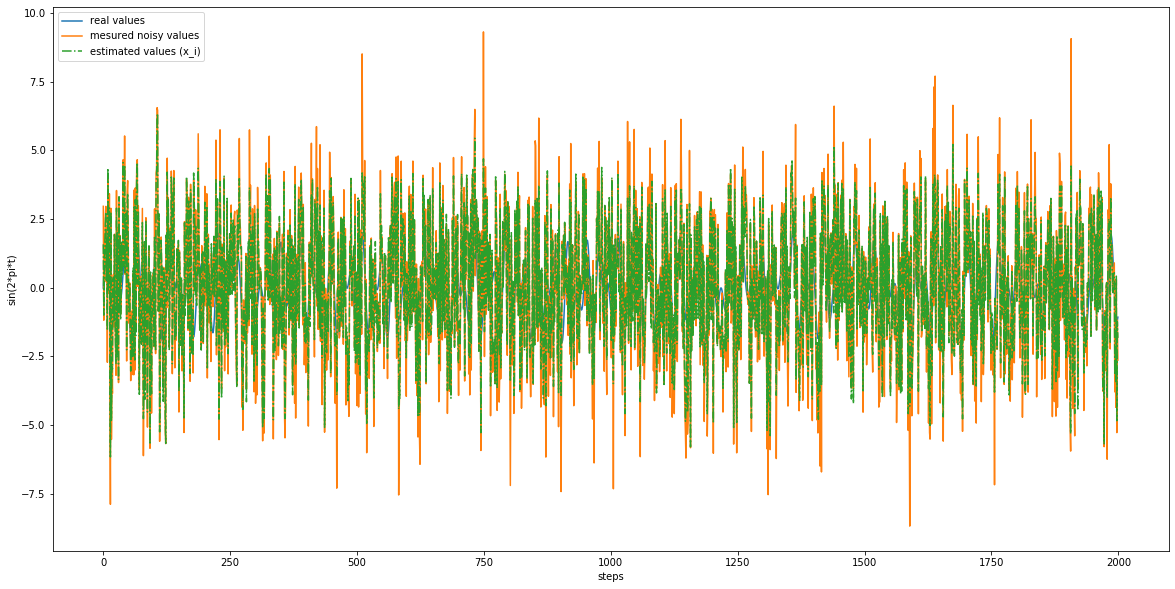

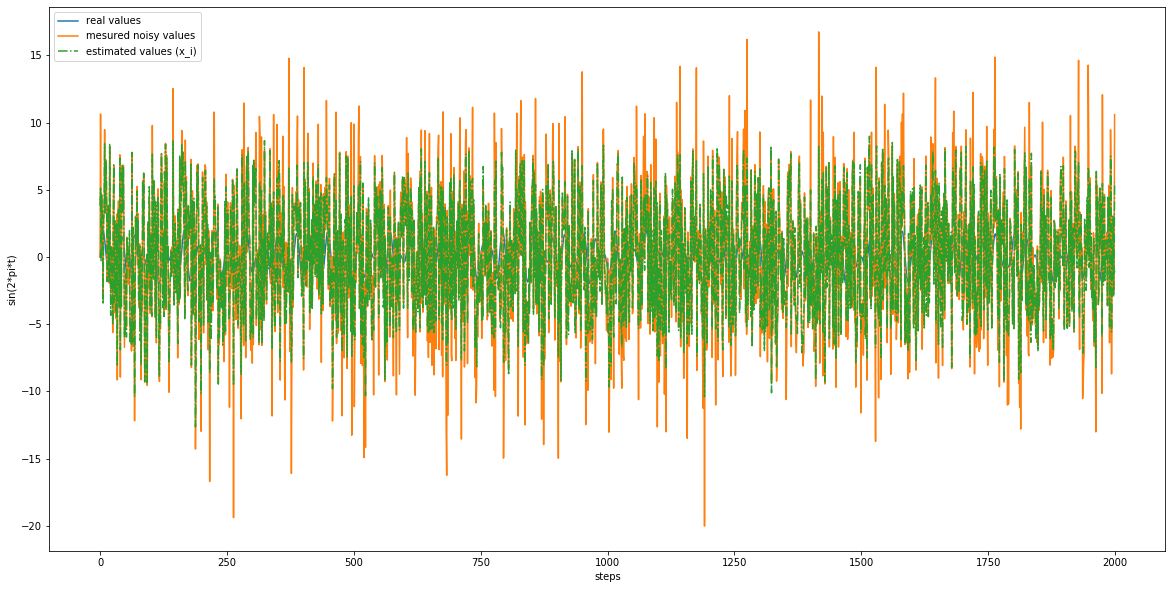

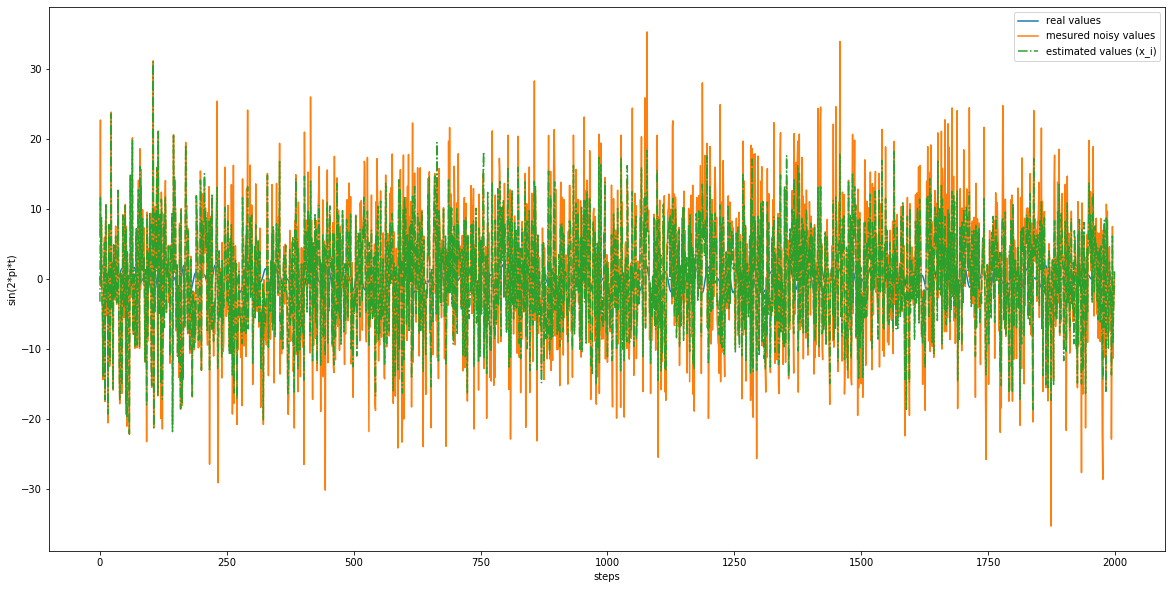

In [5]:
ERR=[]
YYss=[]
YY=[]
xx=[]

for noise_var in [.1,.4,.9,2.4,5,10]:
    
    # importing data
    filename = '2sin.txt'
    data = np.loadtxt(filename)
    n=len(data) #number of data
    m=int(200) #number of training data
    i= np.array(range(n))
    Ys=data.reshape(1,n)
    noise=np.random.normal(0, noise_var, size=(1,n))
    Y=Ys+noise #y0,y1,...,ym+1
    
    # Initializing
    [n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r]=Kalman_in(Y)

    # filtering
    x=Kalman_fil(n,m,Y0,Upsilon,Phi,K,M,T,L,a1,P_1,q,r)
    Ys=Ys.reshape(n)
    Y=Y.reshape(n)
    x=np.array(x).reshape(n)
    YYss.append(Ys)
    YY.append(Y)
    xx.append(x)

    ERR.append(mean_squared_error(Ys[m:],x[m:]))

    plt.figure(figsize=(20,10))
    plt.ylabel('sin(2*pi*t)')
    plt.xlabel('steps')
    plt.plot(Ys,label='real values')
    plt.plot(Y,label='mesured noisy values',linestyle="-")
    plt.plot(x,label='estimated values (x_i)',linestyle="-.")

    plt.legend()

plt.show()

In [9]:
ERR

[0.04135918054680363,
 0.13508563239118548,
 0.5549703758173106,
 4.122479130045423,
 16.709460462204095,
 52.659503070148105]